In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.datasets import load_iris
import pickle
%matplotlib inline

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, bias, verbose, C):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = []
        self.val_loss = []
        self.C = C # 正則化用のパラメータ        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.no_bias == False:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None and y_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
            
        n_col = X.shape[1] # Xの列数を取得
        self.coef_ =  np.random.rand(n_col) # パラメーターの初期化 
        
        for i in range(self.iter):
            error = self._f(X)-y
            self.coef_ = self._gradient_descent(X, error)
            self.loss.append(self._loss_f(self._f(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_f(self._f(X_val), y_val))

            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print(self.coef_)

                
    def load_coef(self, path):
        #.npzから読み出し
        arr = np.load(path)
        self.coef_ = arr['coef']

        
    def save_coef(self, path): 
        #.npzに書き込み
        np.savez(path, coef = self.coef_)

            
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            X = np.insert(X, 0, 1, axis=1)        
        
        y_pred = np.where(self._f(X) >= 0.5, 1, 0)
        
        return y_pred 
    
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            X = np.insert(X, 0, 1, axis=1) 
            
        p1 = self._f(X)
        p0 = 1- p1
        y_pred_proba = np.vstack([p0,p1]).T
        
        
        return y_pred_proba 
    
    
    def _gradient_descent(self, X, error):
        """
        最急降下法により学習させる

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        error : float
            誤差
            
        Returns
        theta : 次の形のndarray, shape (n_features,)
          パラメータ        
        """
        
        m = X.shape[0]
        
        if self.no_bias == False:
            theta = self.coef_ - self.lr*(error@X/m + (self.C/m)*np.hstack([0, self.coef_[1:]]))
        else:
            theta = self.coef_ - self.lr*(error@X/m + (self.C/m)*self.coef_)           
            
        return  theta

     
    def _f(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
        y : 次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        y = 1/(1 + np.exp(-np.dot(X, self.coef_.T)))
        
        return y
    
    
    def _loss_f(self, y_pred, y):
        """
        目的関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
        m : float
          目的関数の値

        """
        m = y.shape[0]
        loss = (-y.T@np.log(y_pred) - (1-y).T@np.log(1 - y_pred))/m + self.C*np.sum(np.square(self.coef_))/(2*m)
        
        return loss
        


# 【問題1】仮定関数

## ロジスティック回帰の仮定関数
# $h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}$

#### $x$：特徴量ベクトル  
#### $\theta$：パラメータ（重み）ベクトル

## 仮定関数の実装

```python  
def _f(self, X):
    """
    線形の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ

    Returns
    -------
    y : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果

    """
    y = 1/(1 + np.exp(-np.dot(X, self.coef_.T)))

    return y
```

# 【問題2】最急降下法

## $\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}　$　　　　　　　　$j = 0$

## $\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j $　　　$j\geq 1$

## gradient descent の実装
```python 
def _gradient_descent(self, X, error):
    """
    最急降下法により学習させる

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    error : float
        誤差

    Returns
    theta : 次の形のndarray, shape (n_features,)
      パラメータ        
    """

    m = X.shape[0]

    if self.no_bias == False:
        theta = self.coef_ - self.lr*(error@X/m + (self.C/m)*np.hstack([0, self.coef_[1:]]))
    else:
        theta = self.coef_ - self.lr*(error@X/m + (self.C/m)*self.coef_)           

    return  theta
```

## fit の実装
```python 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.no_bias == False:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None and y_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
            
        n_col = X.shape[1] # Xの列数を取得
        self.coef_ =  np.random.rand(n_col) # パラメーターの初期化 
        
        for i in range(self.iter):
            error = self._f(X)-y
            self.coef_= self._gradient_descent(X, error)
            self.loss.append(self._loss_f(self._f(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_f(self._f(X_val), y_val))

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)
            if X_val is not None and y_val is not None:
                print(self.val_loss)
```

# 【問題3】推定

## predict の実装
```python 
def predict(self, X):
    """
    ロジスティック回帰を使いラベルを推定する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        ロジスティック回帰による推定結果
    """
    if self.no_bias == False:
        X = np.insert(X, 0, 1, axis=1)        

    y_pred = np.where(self._f(X) >= 0.5, 1, 0)

    return y_pred 
```

## predict proba の実装
```python 
def predict_proba(self, X):
    """
    ロジスティック回帰を使い確率を推定する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, 1)
        ロジスティック回帰による推定結果
    """
    if self.no_bias == False:
        X = np.insert(X, 0, 1, axis=1) 

    p1 = self._f(X)
    p0 = 1- p1
    y_pred_proba = np.vstack([p0,p1]).T


    return y_pred_proba 
```

# 【問題4】目的関数

# $ J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +\frac{λ}{2m}\sum_{j=1}^nθ^2_j\\ $

## 目的関数の実装
```python 
def _loss_f(self, y_pred, y):
    """
    目的関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ

    Returns
    -------
    m : float
      目的関数の値

    """
    m = y.shape[0]
    loss = (-y.T@np.log(y_pred) - (1-y).T@np.log(1 - y_pred))/m + self.C*np.sum(np.square(self.coef_))/(2*m)

    return loss
```

# 【問題5】学習と推定

In [3]:
iris = load_iris() # irisデータの読み込み

df_X = pd.DataFrame(iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width']) 
df_y = pd.DataFrame(iris.target, columns=["species"]) # {0: 'setosa', 1:'versicolor', 2:'virginica'}
df_Xy = pd.concat([df_X, df_y], axis = 1)

# 「versicolor」と「virginica」を抽出
df_Xy = df_Xy.loc[(df_Xy['species']==1) | (df_Xy['species']==2),['sepal_length','sepal_width','petal_length','petal_width','species']] 
df_X = df_Xy[['sepal_length','sepal_width','petal_length','petal_width']]
df_y = df_Xy['species']

In [4]:
#　訓練データと検証データに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_X.values, df_y.values, test_size = 0.25, random_state = 0) # 訓練データ75%、検証データ25%として分割

In [5]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [6]:
# 目的変数の値を「0」「1」に変更
y_train = y_train - 1
y_val= y_val- 1

In [7]:
# 学習
slr = ScratchLogisticRegression(5000, 0.01, False, False, 0.1)
slr.fit(X_train_std, y_train,X_val_std, y_val)

In [8]:
# 推定（trainデータ）
y_train_pred = slr.predict(X_train_std)
print(y_train_pred)
print(y_train)

[0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0
 0]
[0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0
 0]


In [9]:
# 推定（valデータ）
y_val_pred = slr.predict(X_val_std)
y_val_pred_proba = slr.predict_proba(X_val_std)
print(y_val_pred)
print(y_val)
print(y_val_pred_proba)

[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0]
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
[[8.19739053e-01 1.80260947e-01]
 [4.77000017e-03 9.95230000e-01]
 [7.98404891e-01 2.01595109e-01]
 [6.22325564e-04 9.99377674e-01]
 [3.07898358e-02 9.69210164e-01]
 [2.34156820e-03 9.97658432e-01]
 [8.83823547e-01 1.16176453e-01]
 [1.94001764e-01 8.05998236e-01]
 [3.21452214e-03 9.96785478e-01]
 [1.27200914e-02 9.87279909e-01]
 [4.08743772e-02 9.59125623e-01]
 [5.96545045e-02 9.40345495e-01]
 [6.38588264e-03 9.93614117e-01]
 [8.66059319e-01 1.33940681e-01]
 [9.99085176e-01 9.14823937e-04]
 [9.93510467e-01 6.48953270e-03]
 [4.46846322e-01 5.53153678e-01]
 [9.77529781e-01 2.24702193e-02]
 [2.65620118e-01 7.34379882e-01]
 [9.47106224e-01 5.28937761e-02]
 [9.98873903e-01 1.12609650e-03]
 [1.55891293e-02 9.84410871e-01]
 [9.54448469e-01 4.55515312e-02]
 [7.51857319e-02 9.24814268e-01]
 [9.90861361e-01 9.13863932e-03]]


In [10]:
from sklearn.metrics import accuracy_score
print("Accuracy（正解率）：　{}\n".format(accuracy_score(y_val, y_val_pred)))

from sklearn.metrics import precision_score
print("Precision（適合率）：　{}\n".format(precision_score(y_val, y_val_pred, average='macro')))

from sklearn.metrics import recall_score
print("Recall（再現率）：　{}\n".format(recall_score(y_val, y_val_pred, average='macro')))

Accuracy（正解率）：　0.92

Precision（適合率）：　0.9285714285714286

Recall（再現率）：　0.9230769230769231



# 【問題6】学習曲線のプロット

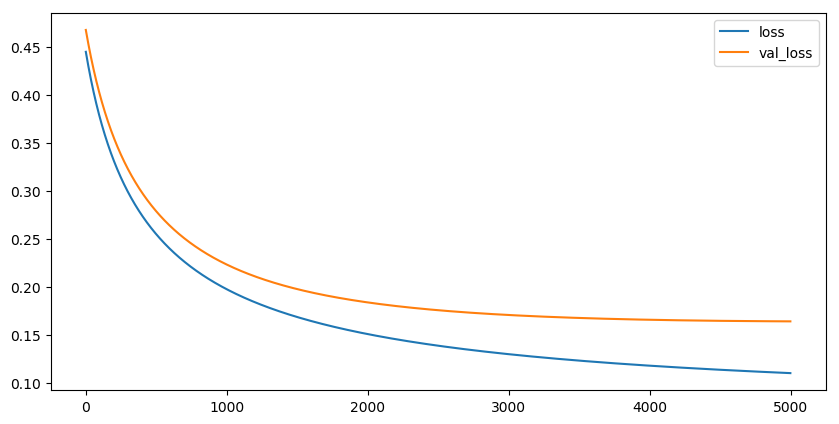

In [11]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(slr.loss, label='loss')
plt.plot(slr.val_loss, label='val_loss')
plt.legend()

# 【問題7】決定領域の可視化

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 決定領域を表示する関数
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [13]:
df_Xy.head()

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


In [14]:
df_X1 = df_Xy[['sepal_length','sepal_width']]
df_X2 = df_Xy[['petal_length','petal_width']]

In [15]:
#　訓練データと検証データに分割
from sklearn.model_selection import train_test_split

# 訓練データ75%、検証データ25%として分割
X1_train, X1_val, y1_train, y1_val = train_test_split(df_X1.values, df_y.values, test_size = 0.25, random_state = 0)
X2_train, X2_val, y2_train, y2_val = train_test_split(df_X2.values, df_y.values, test_size = 0.25, random_state = 0)

In [16]:
# 標準化
from sklearn.preprocessing import StandardScaler

scaler1= StandardScaler()
scaler1.fit(X1_train)
X1_train_std = scaler1.transform(X1_train)
X1_val_std = scaler1.transform(X1_val)

scaler2= StandardScaler()
scaler2.fit(X2_train)
X2_train_std = scaler2.transform(X2_train)
X2_val_std = scaler2.transform(X2_val)

In [17]:
# 目的変数の値を「0」「1」に変更
y1_train = y1_train - 1
y1_val= y1_val- 1

y2_train = y2_train - 1
y2_val = y2_val- 1

In [18]:
# 学習
slr1 = ScratchLogisticRegression(5000, 0.01, False, False, 0.1)
slr1.fit(X1_train_std, y1_train, X1_val_std, y1_val)

slr2 = ScratchLogisticRegression(5000, 0.01, False, False, 0.1)
slr2.fit(X2_train_std, y2_train, X2_val_std, y2_val)

In [19]:
# 推定
y1_val_pred = slr1.predict(X1_val_std)
y2_val_pred = slr2.predict(X2_val_std)

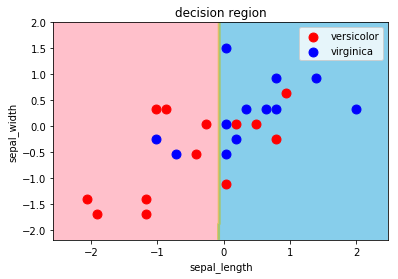

In [20]:
decision_region(X1_val_std, y1_val, slr1, step=0.01, title='decision region', xlabel='sepal_length', ylabel='sepal_width', target_names=['versicolor', 'virginica'])

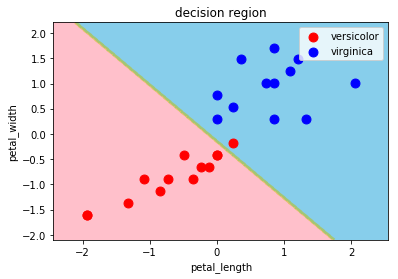

In [21]:
decision_region(X2_val_std, y2_val, slr2, step=0.01, title='decision region', xlabel='petal_length', ylabel='petal_width', target_names=['versicolor', 'virginica'])

# 【問題8】（アドバンス課題）重みの保存

## 学習した重みを保存する関数の実装
```python 
def save_coef(self, path): 
    #.npzに書き込み
    np.savez(path, coef = self.coef_)
```

## 保存した重みを読み込む関数の実装
```python 
def load_coef(self, path):
    #.npzから読み出し
    arr = np.load(path)
    self.coef_ = arr['coef']
```

In [22]:
# 学習した重みを保存
slr1.save_coef('coef.npz')
slr1.coef_

array([ 0.09290313,  1.38381333, -0.00336114])

In [23]:
# 新しいインスタンスを作成
slr0 = ScratchLogisticRegression(5000, 0.01, False, False, 0.1)
# 重みを読み込み
slr0.load_coef('coef.npz')

In [24]:
# 予測
slr0.predict(X1_val_std)

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0])